In [ ]:
import fiona
import geopandas as gpd
from shapely.errors import GEOSException
from shapely.geometry import shape

records = []
with fiona.open("/home/nissim/Downloads/raw_L3.geojson") as src:
    crs = src.crs
    for feat in src:
        try:
            geom = shape(feat["geometry"])
            records.append({**feat["properties"], "geometry": geom})
        except GEOSException as e:
            print("Bad geometry skipped:", e)

gdf = gpd.GeoDataFrame(records, crs=crs)


Bad geometry skipped: IllegalArgumentException: point array must contain 0 or >1 elements



In [28]:
gdf.head()

,Name,Description,geometry
0,La Plata,descripción: <br>name: La Plata <br>descriptio...,"MULTIPOLYGON Z (((-57.95329 -34.95318 0, -57.9..."
1,La Plata,descripción: <br>name: La Plata <br>descriptio...,"MULTIPOLYGON Z (((-57.94066 -34.9403 0, -57.94..."


In [ ]:
import re
import zipfile
from io import BytesIO
from pathlib import Path
from tempfile import TemporaryDirectory

import fiona
import geopandas as gpd
import pandas as pd
import requests
from shapely.errors import GEOSException
from shapely.geometry import MultiLineString, shape

barrio_kmz_links = [  # same as before
    (
        "Angel Echeverry",
        "https://www.google.com/maps/d/kml?mid=1LnbbM9SdajyhjPRds9Ha4RqwGmenE_E",
    ),
    (
        "Correas",
        "https://www.google.com/maps/d/kml?mid=1-dhXCme-nqMss3-N-HTGyQH0Md012mQ",
    ),
    ("Arana", "https://www.google.com/maps/d/kml?mid=1npbZeOyLPkt3JyBSx1SQfSfIAzwxjbY"),
    (
        "Altos de San Lorenzo",
        "https://www.google.com/maps/d/kml?mid=1zj9YnqZ_v-PJAwVA4FK9aFWXR_UAejo",
    ),
    (
        "Tolosa",
        "https://www.google.com/maps/d/kml?mid=1THnqnGFmrfAHPbb-ian590fdHCHQOHw",
    ),
    (
        "Ringuelet",
        "https://www.google.com/maps/d/kml?mid=1blWFWPeq9BBp7rSE96NLaEbD9hfHDqM",
    ),
    (
        "Abasto",
        "https://www.google.com/maps/d/kml?mid=1Yo_vWJ8DKRpBWUrEurMAYoqevTwDUJk",
    ),
    (
        "El Peligro",
        "https://www.google.com/maps/d/kml?mid=1nUKD3IoNg4tW1z_ByRnRLplSjVWffFc",
    ),
    (
        "Arturo Seguí",
        "https://www.google.com/maps/d/kml?mid=1S33tGfHRu0HkXDI8zgF-PkC0vqzNS4Y",
    ),
    (
        "Villa Elisa",
        "https://www.google.com/maps/d/kml?mid=1Apex-2Sc-MD2DP6hu8-CjGR5WGNZRKI",
    ),
    (
        "Gorina",
        "https://www.google.com/maps/d/kml?mid=15OvWKIT3o7O9TvOtCpPoItNVcD4-980",
    ),
    (
        "Gonnet",
        "https://www.google.com/maps/d/kml?mid=1ijpHlBkLo4H07mxw1bF0hOtBJDtHKyQ",
    ),
    (
        "Hernández",
        "https://www.google.com/maps/d/kml?mid=1gcAaX7imZ__gLDqwgRyNqzmOTDNTxQg",
    ),
    (
        "El retiro , Olmos",
        "https://www.google.com/maps/d/kml?mid=1Jz00qNoIYbqKscqg834OzNt5wYxdP3E",
    ),
    (
        "Berisso – Maldonado",
        "https://www.google.com/maps/d/kml?mid=1rY94cOsgC8avbjPNrCvlOS1XJ7C4X-8",
    ),
    (
        "City Bell",
        "https://www.google.com/maps/d/kml?mid=1IhbhC2qZypptkVdR5noSZlSBFQiGYDA",
    ),
    (
        "Villa Elvira",
        "https://www.google.com/maps/d/kml?mid=1VlNQDe5WSaVFj4aMiE0nwivnu6PtmbE",
    ),
    (
        "San Carlos",
        "https://www.google.com/maps/d/kml?mid=1wnvHRfAlAmQCr3s1pteqUhEE3Kyzijk",
    ),
    (
        "Melchor Romero",
        "https://www.google.com/maps/d/kml?mid=15fbKPhtLBVnwOxeCLRASlB3xUjLVF4g",
    ),
    (
        "Los Hornos",
        "https://www.google.com/maps/d/kml?mid=18UWwJn5L-WPg6QSrI36aojwHh3CgyHg",
    ),
    (
        "La Plata",
        "https://www.google.com/maps/d/kml?mid=1v-NU8bwhXDXXHWgNOWcd1p4WpvkqULo",
    ),
]

In [ ]:
fiona.drvsupport.supported_drivers["kml"] = "rw"  # enable KML support
fiona.drvsupport.supported_drivers["KML"] = "rw"


In [ ]:
def deduplicate_columns(columns):
    try:
        from pandas.io.parsers import base_parser

        return base_parser.ParserBase({"usecols": None})._maybe_dedup_names(columns)
    except Exception:
        # fallback manual deduplication
        seen = {}
        new_columns = []
        for col in columns:
            if col not in seen:
                seen[col] = 0
                new_columns.append(col)
            else:
                seen[col] += 1
                new_columns.append(f"{col}.{seen[col]}")
        return new_columns


def safe_fiona_to_gdf(kml_path: str, layer: str) -> gpd.GeoDataFrame:
    """Reads and filters features one-by-one to catch broken geometries early."""
    records = []
    with fiona.open(kml_path, layer=layer) as src:
        crs = src.crs
        for idx, feat in enumerate(src):
            try:
                geom = shape(feat["geometry"])
                if geom.geom_type == "LineString" and len(geom.coords) < 2:
                    raise ValueError("LineString with < 2 points")
                if geom.geom_type == "MultiLineString":
                    valid_parts = [g for g in geom.geoms if len(g.coords) >= 2]
                    if not valid_parts:
                        raise ValueError("MultiLineString with no valid parts")
                    geom = MultiLineString(valid_parts)
                records.append({**feat["properties"], "geometry": geom})
            except Exception as e:
                print(f"❌ Skipping feature {idx} in {layer}: {e}")
    if not records:
        return None
    gdf = gpd.GeoDataFrame(records, crs=crs)
    return gdf


def fetch_kmz_as_gdf(kmz_url: str, barrio_name: str) -> gpd.GeoDataFrame:
    response = requests.get(kmz_url)
    response.raise_for_status()
    with TemporaryDirectory() as tmpdir:
        tmpdir_path = Path(tmpdir)
        kmz = zipfile.ZipFile(BytesIO(response.content))
        kmz.extractall(tmpdir_path)
        kml_files = list(tmpdir_path.glob("*.kml"))
        if not kml_files:
            raise ValueError("No KML file found inside KMZ.")
        kml_path = str(kml_files[0])
        layers = fiona.listlayers(kml_path)

        gdfs = []
        for layer in layers:
            gdf = safe_fiona_to_gdf(kml_path, layer)
            if gdf is not None and not gdf.empty:
                gdfs.append(gdf)

        if not gdfs:
            raise ValueError("No valid data found in KMZ.")
        return pd.concat(gdfs, ignore_index=True)


def clean_gdf_from_kml(gdf: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    gdf = gdf[gdf.geometry.notnull()]
    gdf.columns = deduplicate_columns(gdf.columns)

    def extract_attrs(desc):
        attrs = {}
        matches = re.findall(r"(\w+):\s*(.*?)<br>", desc or "")
        for key, value in matches:
            attrs[key.lower()] = value.strip()
        return attrs

    if "Description" in gdf.columns:
        desc_attrs = gdf["Description"].apply(extract_attrs).apply(pd.Series)
        gdf = gdf.drop(columns=["Description"])
        gdf = pd.concat([gdf, desc_attrs], axis=1)

    if gdf.crs is None:
        gdf.set_crs("EPSG:4326", inplace=True)
    if "Name" in gdf.columns:
        gdf = gdf.rename(columns={"Name": "name"})
    return gdf[gdf.is_valid]


all_gdfs = []
for barrio, url in barrio_kmz_links:
    print(f"Fetching {barrio}...")
    try:
        gdf = fetch_kmz_as_gdf(url, barrio)
        if gdf is None:
            raise RuntimeError("Empty or invalid GeoDataFrame")

        cleaned = clean_gdf_from_kml(gdf)
        cleaned["barrio"] = barrio

        cleaned.columns = deduplicate_columns(cleaned.columns)
        all_gdfs.append(cleaned)

    except Exception as e:
        print(f"❌ Failed to process {barrio}: {e}")

if not all_gdfs:
    raise RuntimeError("No valid GeoDataFrames collected.")

combined_gdf = gpd.GeoDataFrame(pd.concat(all_gdfs, ignore_index=True), crs="EPSG:4326")
print(combined_gdf.head())

Fetching Angel Echeverry...
Fetching Correas...
Fetching Arana...
❌ Skipping feature 534 in Arana: IllegalArgumentException: point array must contain 0 or >1 elements

Fetching Altos de San Lorenzo...
Fetching Tolosa...
Fetching Ringuelet...
Fetching Abasto...
Fetching El Peligro...
Fetching Arturo Seguí...
Fetching Villa Elisa...
❌ Skipping feature 543 in Villa Elisa: IllegalArgumentException: point array must contain 0 or >1 elements

Fetching Gorina...
Fetching Gonnet...
Fetching Hernández...
Fetching El retiro , Olmos...
Fetching Berisso – Maldonado...
Fetching City Bell...
Fetching Villa Elvira...
Fetching San Carlos...
❌ Skipping feature 3 in San Carlos: IllegalArgumentException: point array must contain 0 or >1 elements

Fetching Melchor Romero...
Fetching Los Hornos...
Fetching La Plata...
❌ Skipping feature 2 in La Plata (#3): IllegalArgumentException: point array must contain 0 or >1 elements

    name                                           geometry descripción  \
0  media

In [ ]:
# where combined_gdf['description'] is NaN, fill it with the corresponding data from 'descriptio'
# likewise, where 'peligrosidad' is NaN, fill it with the corresponding data from 'peligrosid'
# then drop both 'descriptio' and 'peligrosid' columns
combined_gdf["description"] = combined_gdf["description"].combine_first(
    combined_gdf["descriptio"]
)
combined_gdf["peligrosidad"] = combined_gdf["peligrosidad"].combine_first(
    combined_gdf["peligrosid"]
)

combined_gdf = combined_gdf.drop(columns=["descriptio", "peligrosid"])
combined_gdf.head()

,name,geometry,descripción,gid,name.1,id,cuenca,barrio,description,peligrosidad
0,media,"POLYGON Z ((-57.95406 -35.09486 0, -57.95307 -...",,39781,Angel Etcheverry,30776.0,Cuenca Arroyo El Pescado,Angel Echeverry,LA PLATA,media
1,media,"POLYGON Z ((-58.00747 -35.09514 0, -58.00528 -...",,39471,Angel Etcheverry,465.0,Cuenca Arroyo Abascay,Angel Echeverry,LA PLATA,media
2,media,"POLYGON Z ((-57.9787 -35.09223 0, -57.97772 -3...",,39782,Angel Etcheverry,30782.0,Cuenca Arroyo El Pescado,Angel Echeverry,LA PLATA,media
3,media,"POLYGON Z ((-57.97268 -35.08336 0, -57.97169 -...",,39813,Angel Etcheverry,30894.0,Cuenca Arroyo El Pescado,Angel Echeverry,LA PLATA,media
4,media,"POLYGON Z ((-57.97676 -35.09468 0, -57.97577 -...",,39780,Angel Etcheverry,30775.0,Cuenca Arroyo El Pescado,Angel Echeverry,LA PLATA,media


In [43]:
combined_gdf.shape

(15997, 10)

<Axes: >

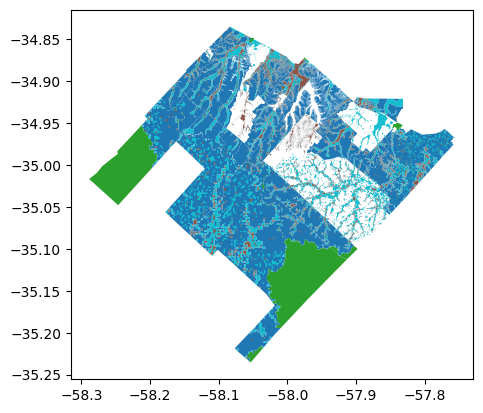

In [ ]:
combined_gdf.plot("peligrosidad")

In [ ]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import shape

barrio_kmz_links = [  # same as before
    (
        "Angel Echeverry",
        "https://www.google.com/maps/d/kml?mid=1LnbbM9SdajyhjPRds9Ha4RqwGmenE_E",
    ),
    (
        "Correas",
        "https://www.google.com/maps/d/kml?mid=1-dhXCme-nqMss3-N-HTGyQH0Md012mQ",
    ),
    ("Arana", "https://www.google.com/maps/d/kml?mid=1npbZeOyLPkt3JyBSx1SQfSfIAzwxjbY"),
    (
        "Altos de San Lorenzo",
        "https://www.google.com/maps/d/kml?mid=1zj9YnqZ_v-PJAwVA4FK9aFWXR_UAejo",
    ),
    (
        "Tolosa",
        "https://www.google.com/maps/d/kml?mid=1THnqnGFmrfAHPbb-ian590fdHCHQOHw",
    ),
    (
        "Ringuelet",
        "https://www.google.com/maps/d/kml?mid=1blWFWPeq9BBp7rSE96NLaEbD9hfHDqM",
    ),
    (
        "Abasto",
        "https://www.google.com/maps/d/kml?mid=1Yo_vWJ8DKRpBWUrEurMAYoqevTwDUJk",
    ),
    (
        "El Peligro",
        "https://www.google.com/maps/d/kml?mid=1nUKD3IoNg4tW1z_ByRnRLplSjVWffFc",
    ),
    (
        "Arturo Seguí",
        "https://www.google.com/maps/d/kml?mid=1S33tGfHRu0HkXDI8zgF-PkC0vqzNS4Y",
    ),
    (
        "Villa Elisa",
        "https://www.google.com/maps/d/kml?mid=1Apex-2Sc-MD2DP6hu8-CjGR5WGNZRKI",
    ),
    (
        "Gorina",
        "https://www.google.com/maps/d/kml?mid=15OvWKIT3o7O9TvOtCpPoItNVcD4-980",
    ),
    (
        "Gonnet",
        "https://www.google.com/maps/d/kml?mid=1ijpHlBkLo4H07mxw1bF0hOtBJDtHKyQ",
    ),
    (
        "Hernández",
        "https://www.google.com/maps/d/kml?mid=1gcAaX7imZ__gLDqwgRyNqzmOTDNTxQg",
    ),
    (
        "El retiro , Olmos",
        "https://www.google.com/maps/d/kml?mid=1Jz00qNoIYbqKscqg834OzNt5wYxdP3E",
    ),
    (
        "Berisso – Maldonado",
        "https://www.google.com/maps/d/kml?mid=1rY94cOsgC8avbjPNrCvlOS1XJ7C4X-8",
    ),
    (
        "City Bell",
        "https://www.google.com/maps/d/kml?mid=1IhbhC2qZypptkVdR5noSZlSBFQiGYDA",
    ),
    (
        "Villa Elvira",
        "https://www.google.com/maps/d/kml?mid=1VlNQDe5WSaVFj4aMiE0nwivnu6PtmbE",
    ),
    (
        "San Carlos",
        "https://www.google.com/maps/d/kml?mid=1wnvHRfAlAmQCr3s1pteqUhEE3Kyzijk",
    ),
    (
        "Melchor Romero",
        "https://www.google.com/maps/d/kml?mid=15fbKPhtLBVnwOxeCLRASlB3xUjLVF4g",
    ),
    (
        "Los Hornos",
        "https://www.google.com/maps/d/kml?mid=18UWwJn5L-WPg6QSrI36aojwHh3CgyHg",
    ),
    (
        "La Plata",
        "https://www.google.com/maps/d/kml?mid=1v-NU8bwhXDXXHWgNOWcd1p4WpvkqULo",
    ),
]

import fiona
import geopandas as gpd
import pandas as pd
from shapely.errors import GEOSException
from shapely.geometry import shape


def deduplicate_columns(columns):
    seen = {}
    new_columns = []
    for col in columns:
        if col not in seen:
            seen[col] = 0
            new_columns.append(col)
        else:
            seen[col] += 1
            new_columns.append(f"{col}.{seen[col]}")
    return new_columns


def clean_geometry(geom):
    if geom is None:
        return None
    if geom.geom_type == "LineString":
        if len(geom.coords) < 2:
            return None
    elif geom.geom_type == "MultiLineString":
        lines = [l for l in geom.geoms if len(l.coords) >= 2]
        if not lines:
            return None
        return MultiLineString(lines)
    return geom


def fetch_kmz_as_gdf(kmz_url: str) -> gpd.GeoDataFrame:
    response = requests.get(kmz_url)
    response.raise_for_status()
    with TemporaryDirectory() as tmpdir:
        tmpdir_path = Path(tmpdir)
        kmz = zipfile.ZipFile(BytesIO(response.content))
        kmz.extractall(tmpdir_path)
        kml_files = list(tmpdir_path.glob("*.kml"))
        if not kml_files:
            raise ValueError("No KML file found inside KMZ.")
        kml_path = str(kml_files[0])

        all_layers = fiona.listlayers(kml_path)
        gdfs = []

        for layer in all_layers:
            try:
                gdf = gpd.read_file(kml_path, layer=layer)
                if not gdf.empty:
                    gdfs.append(gdf)
            except Exception as e:
                print(f"⚠️ Skipping layer {layer}: {e}")

        if not gdfs:
            raise ValueError("No valid layers found in KMZ.")

        return pd.concat(gdfs, ignore_index=True)


def clean_gdf_from_kml(gdf: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    gdf = gdf[gdf.geometry.notnull()]
    gdf = gdf[gdf.is_valid]
    try:
        gdf["geometry"] = gdf.geometry.apply(clean_geometry)
        gdf = gdf[gdf.geometry.notnull()]
    except GEOSException:
        gdf = gdf[gdf.is_valid]

    def extract_attrs(desc):
        attrs = {}
        matches = re.findall(r"(\w+):\s*(.*?)<br>", desc or "")
        for key, value in matches:
            attrs[key.lower()] = value.strip()
        return attrs

    if "Description" in gdf.columns:
        desc_attrs = gdf["Description"].apply(extract_attrs).apply(pd.Series)
        gdf = gdf.drop(columns=["Description"])
        gdf = pd.concat([gdf, desc_attrs], axis=1)

    if gdf.crs is None:
        gdf.set_crs("EPSG:4326", inplace=True)

    if "Name" in gdf.columns:
        gdf = gdf.rename(columns={"Name": "name"})

    gdf.columns = deduplicate_columns(gdf.columns)
    return gdf[gdf.is_valid]


all_gdfs = []
for barrio, url in barrio_kmz_links:
    print(f"Fetching {barrio}...")
    try:
        gdf = fetch_kmz_as_gdf(url)
        cleaned = clean_gdf_from_kml(gdf)
        cleaned["barrio"] = barrio
        all_gdfs.append(cleaned)
    except Exception as e:
        print(f"❌ Failed to process {barrio}: {e}")

if not all_gdfs:
    raise RuntimeError("No valid GeoDataFrames collected.")

# Final concat (deduping columns ahead of time already)
combined_gdf = gpd.GeoDataFrame(pd.concat(all_gdfs, ignore_index=True), crs="EPSG:4326")
print(combined_gdf.head())


Fetching Angel Echeverry...
Fetching Correas...
Fetching Arana...
⚠️ Skipping layer Arana: IllegalArgumentException: point array must contain 0 or >1 elements

❌ Failed to process Arana: No valid layers found in KMZ.
Fetching Altos de San Lorenzo...
Fetching Tolosa...
Fetching Ringuelet...
Fetching Abasto...
Fetching El Peligro...
Fetching Arturo Seguí...
Fetching Villa Elisa...
⚠️ Skipping layer Villa Elisa: IllegalArgumentException: point array must contain 0 or >1 elements

❌ Failed to process Villa Elisa: No valid layers found in KMZ.
Fetching Gorina...
Fetching Gonnet...
Fetching Hernández...
Fetching El retiro , Olmos...
Fetching Berisso – Maldonado...
Fetching City Bell...
Fetching Villa Elvira...
Fetching San Carlos...
⚠️ Skipping layer San Carlos: IllegalArgumentException: point array must contain 0 or >1 elements

Fetching Melchor Romero...
Fetching Los Hornos...
Fetching La Plata...
⚠️ Skipping layer La Plata (#3): IllegalArgumentException: point array must contain 0 or >1 e

In [22]:
combined_gdf.tail()

,name,geometry,descripción,gid,name.1,descriptio,id,cuenca,peligrosid,barrio,description,peligrosidad
13116,La Plata,"POLYGON Z ((-57.93649 -34.93926 0, -57.93649 -...",,NaN,La Plata,NaN,179,Cuenca Arroyo Circunvalacion,NaN,La Plata,LA PLATA,alta
13117,La Plata,GEOMETRYCOLLECTION Z (LINESTRING Z (-57.94451 ...,,NaN,La Plata,NaN,219,Cuenca Arroyo del Zoologico,NaN,La Plata,LA PLATA,media
13118,La Plata,GEOMETRYCOLLECTION Z (LINESTRING Z (-57.92412 ...,,NaN,La Plata,NaN,19,Cuenca Arroyo del Zoologico,NaN,La Plata,LA PLATA,Muy Baja a Nula
13119,La Plata,"MULTIPOLYGON Z (((-57.95109 -34.95247 0, -57.9...",,NaN,La Plata,NaN,112,Cuenca Arroyo El Gato,NaN,La Plata,LA PLATA,Muy Baja a Nula
13120,La Plata,"MULTIPOLYGON Z (((-57.93016 -34.93352 0, -57.9...",,NaN,La Plata,NaN,145,Cuenca Arroyo Circunvalacion,NaN,La Plata,LA PLATA,Muy Baja a Nula


<Axes: >

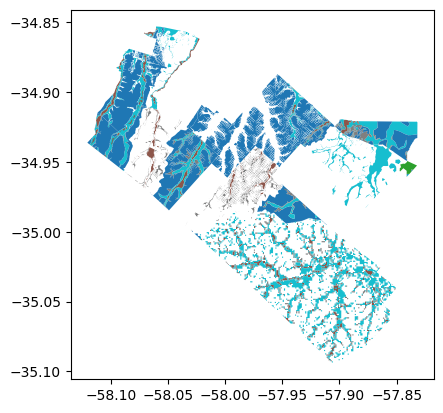

In [ ]:
combined_gdf.plot("peligrosidad")

In [8]:
cleaned_gdf = clean_gdf_from_kml(gdf)
print(cleaned_gdf.columns)
print(cleaned_gdf.dtypes)

Index(['name', 'geometry', 'descripción', 'gid', 'name', 'descriptio', 'id',
       'cuenca', 'peligrosid'],
      dtype='object')
name             object
geometry       geometry
descripción      object
gid              object
name             object
descriptio       object
id               object
cuenca           object
peligrosid       object
dtype: object


In [11]:
cleaned_gdf.head()

,name,geometry,descripción,gid,name,descriptio,id,cuenca,peligrosid
0,media,"POLYGON Z ((-57.95406 -35.09486 0, -57.95307 -...",,39781,Angel Etcheverry,LA PLATA,30776.0,Cuenca Arroyo El Pescado,media
1,media,"POLYGON Z ((-58.00747 -35.09514 0, -58.00528 -...",,39471,Angel Etcheverry,LA PLATA,465.0,Cuenca Arroyo Abascay,media
2,media,"POLYGON Z ((-57.9787 -35.09223 0, -57.97772 -3...",,39782,Angel Etcheverry,LA PLATA,30782.0,Cuenca Arroyo El Pescado,media
3,media,"POLYGON Z ((-57.97268 -35.08336 0, -57.97169 -...",,39813,Angel Etcheverry,LA PLATA,30894.0,Cuenca Arroyo El Pescado,media
4,media,"POLYGON Z ((-57.97676 -35.09468 0, -57.97577 -...",,39780,Angel Etcheverry,LA PLATA,30775.0,Cuenca Arroyo El Pescado,media


In [10]:
cleaned_gdf.describe()

,name,geometry,descripción,gid,name,descriptio,id,cuenca,peligrosid
count,695,695,695,695,695,695,695,695,695
unique,5,695,1,695,1,1,695,3,5
top,media,"POLYGON Z ((-58.013959 -35.08788 0, -58.011766...",,39773,Angel Etcheverry,LA PLATA,1888.0,Cuenca Arroyo Abascay,media
freq,456,1,695,1,695,695,1,413,456
